In [20]:
# setup
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt 
import requests
import calendar
import geopandas as gpd
import os.path as os
import scipy.stats
import seaborn.palettes
import seaborn.utils
import sys
import http.client, urllib.request, urllib.parse, urllib.error, base64
#import config
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture

In [23]:
df_box= pd.read_csv('/Users/bayerd01/Documents/ML CITIES/analysis_box.csv').drop(["Unnamed: 0"], axis = 1)
df_box.head()

,borobox,lotarea,bldgarea,numbldgs,numfloors,unitsres,unitstotal,assessland,assesstot,exempttot,...,pctnhtwoplus,pctownerocch,pctrentocch,crowding,crowdingrenter,engines_assigned_quantity,ladders_assigned_quantity,dispatch_response_seconds_qy,num_fire_ev,avg_fire_ev_yr
0,B0020,3457.956522,9239.391304,1.173913,3.521739,9.000000,9.043478,3.718826e+04,8.482943e+05,2.937391e+03,...,3.109101,17.874693,82.125307,6.511057,6.806283,3.500000,2.333333,32.666667,6,1.200000
1,B0023,26081.875000,209572.375000,1.000000,18.750000,229.750000,231.125000,1.322048e+06,1.219295e+07,2.589945e+06,...,4.795929,10.082423,89.917577,8.626047,7.280303,3.000000,2.000000,42.333333,3,3.000000
2,B0024,2754.847826,4832.108696,1.086957,3.217391,5.695652,5.847826,4.959654e+04,5.346010e+05,4.643715e+04,...,4.842301,9.965636,90.034364,8.719931,7.156489,3.200000,2.040000,36.880000,25,1.923077
3,B0025,61653.000000,85292.250000,1.250000,10.750000,101.500000,102.000000,8.558175e+05,3.580575e+06,2.746800e+06,...,4.842301,9.965636,90.034364,8.719931,7.156489,2.400000,1.600000,15.600000,5,1.666667
4,B0027,3888.574713,8242.965517,1.126437,3.183908,7.080460,7.402299,4.881548e+04,6.619610e+05,1.669940e+05,...,4.842301,9.965636,90.034364,8.719931,7.156489,3.545455,2.340909,32.181818,44,2.933333


PART I: CLUSTER ANALYSIS WITHOUT TARGET VARIABLE (PREDICTION)

A. DATA PREP

In [105]:
df_box.columns
predictors = ["lotarea", "bldgarea", "numbldgs", "numfloors", "unitsres", "unitstotal", "assessland",
             "assesstot", "exempttot", "yearbuilt", 
              #"holc_AB", "holc_CD", "holc_D", remove binary
             "tot_hpd_vio", "hpd_fire_vio", "hpd_b_c_vio",
             "viol_count_per_unit", "hpd_fire_vio_per_unit", "hpd_b_c_vio_per_unit",
             "AL", "NB", "average_energy_usage", "average_energy_usage_mi"]
predictors_acs= df_box.columns[df_box.columns.get_loc("totpop"):df_box.columns.get_loc("crowdingrenter") + 1].tolist()
predictors_full= predictors + predictors_acs
predictors_full

['lotarea',
 'bldgarea',
 'numbldgs',
 'numfloors',
 'unitsres',
 'unitstotal',
 'assessland',
 'assesstot',
 'exempttot',
 'yearbuilt',
 'tot_hpd_vio',
 'hpd_fire_vio',
 'hpd_b_c_vio',
 'viol_count_per_unit',
 'hpd_fire_vio_per_unit',
 'hpd_b_c_vio_per_unit',
 'AL',
 'NB',
 'average_energy_usage',
 'average_energy_usage_mi',
 'totpop',
 'popdens',
 'areasqmile',
 'males',
 'females',
 'pop18under',
 'pop18_34',
 'pop35_64',
 'pop65plus',
 'pophispanic',
 'popnhwhite',
 'popnhblack',
 'popnhaian',
 'popnhasian',
 'popnhhawainpi',
 'popnhother',
 'popnhtwoplus',
 'housing',
 'housingoccupied',
 'renterhousing',
 'oc_halfless',
 'oc_half_1',
 'oc_1_onehalf',
 'oc_onehalf_2',
 'oc_2plus',
 'roc_halfless',
 'roc_half_1',
 'roc_1_onehalf',
 'roc_onehalf_2',
 'roc_2plus',
 'medianyearbuilt',
 'mediangrossrent',
 'medianhhincome',
 'gini',
 'year',
 'pct18under',
 'pct18_34',
 'pct35_64',
 'pct65plus',
 'pcthispanic',
 'pctnhwhite',
 'pctnhblack',
 'pctnhaian',
 'pctnhasian',
 'pctnhhawainpi'

In [106]:
predictors = df_box.loc[:, predictors_full].fillna(0)

In [107]:
predictors

,lotarea,bldgarea,numbldgs,numfloors,unitsres,unitstotal,assessland,assesstot,exempttot,yearbuilt,...,pctnhblack,pctnhaian,pctnhasian,pctnhhawainpi,pctnhother,pctnhtwoplus,pctownerocch,pctrentocch,crowding,crowdingrenter
0,3457.956522,9239.391304,1.173913,3.521739,9.000000,9.043478,3.718826e+04,8.482943e+05,2.937391e+03,1929.000000,...,5.907292,1.130582,6.444319,0.0,2.091577,3.109101,17.874693,82.125307,6.511057,6.806283
1,26081.875000,209572.375000,1.000000,18.750000,229.750000,231.125000,1.322048e+06,1.219295e+07,2.589945e+06,1995.750000,...,5.007916,0.000000,8.927436,0.0,0.076276,4.795929,10.082423,89.917577,8.626047,7.280303
2,2754.847826,4832.108696,1.086957,3.217391,5.695652,5.847826,4.959654e+04,5.346010e+05,4.643715e+04,1930.347826,...,5.176252,0.000000,6.437848,0.0,0.000000,4.842301,9.965636,90.034364,8.719931,7.156489
3,61653.000000,85292.250000,1.250000,10.750000,101.500000,102.000000,8.558175e+05,3.580575e+06,2.746800e+06,1958.250000,...,5.176252,0.000000,6.437848,0.0,0.000000,4.842301,9.965636,90.034364,8.719931,7.156489
4,3888.574713,8242.965517,1.126437,3.183908,7.080460,7.402299,4.881548e+04,6.619610e+05,1.669940e+05,1929.057471,...,5.176252,0.000000,6.437848,0.0,0.000000,4.842301,9.965636,90.034364,8.719931,7.156489
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10859,13611.500000,31399.111111,1.111111,3.277778,22.944444,27.666667,1.475517e+05,9.007483e+05,5.954489e+04,1978.666667,...,10.495983,0.000000,3.562696,0.0,0.943067,2.759343,42.171518,57.828482,0.511408,0.884354
10860,15973.769231,50165.000000,1.692308,3.538462,40.230769,40.230769,2.006309e+05,1.288421e+06,3.477946e+04,1788.615385,...,5.998493,0.000000,5.958270,0.0,0.352624,2.214461,55.931568,44.068432,1.848746,4.064422
10861,11057.809524,3360.285714,1.095238,2.190476,1.047619,1.047619,2.705429e+04,1.204286e+05,2.555143e+04,1931.714286,...,6.467723,0.000000,4.819578,0.0,0.238157,2.297518,54.314634,45.685366,1.173006,2.671453
10862,15604.521739,11903.260870,1.217391,2.695652,11.869565,11.869565,1.316296e+05,3.087378e+05,2.570439e+05,1958.913043,...,4.839349,0.000000,7.338358,0.0,0.000000,2.737009,63.080408,36.919592,4.530011,10.122699


JUST FEATURE IMPORTANCE FIELDS:

In [74]:
imp_feat = ["hpd_b_c_vio", "bldgarea", "tot_hpd_vio", "hpd_b_c_vio_per_unit", "unitstotal", "pop65plus",
           "unitsres","pctnhblack","hpd_fire_vio","mediangrossrent"]


In [75]:
imp_feat = df_box.loc[:, imp_feat].fillna(0)

In [76]:
imp_feat

,hpd_b_c_vio,bldgarea,tot_hpd_vio,hpd_b_c_vio_per_unit,unitstotal,pop65plus,unitsres,pctnhblack,hpd_fire_vio,mediangrossrent
0,7.739130,9239.391304,14.608696,0.957782,9.043478,431.000000,9.000000,5.907292,0.086957,2093.000000
1,1.125000,209572.375000,3.750000,0.010057,231.125000,568.750000,229.750000,5.007916,0.000000,2170.250000
2,4.586957,4832.108696,8.804348,0.712707,5.847826,596.000000,5.695652,5.176252,0.108696,2027.000000
3,0.000000,85292.250000,3.750000,0.000000,102.000000,596.000000,101.500000,5.176252,0.000000,2027.000000
4,9.632184,8242.965517,16.114943,1.405932,7.402299,596.000000,7.080460,5.176252,0.183908,2027.000000
...,...,...,...,...,...,...,...,...,...,...
10859,4.500000,31399.111111,7.333333,0.025093,27.666667,1699.000000,22.944444,10.495983,0.000000,1963.000000
10860,22.000000,50165.000000,30.230769,0.940423,40.230769,388.769231,40.230769,5.998493,0.153846,1602.384615
10861,0.000000,3360.285714,0.000000,0.000000,1.047619,407.428571,1.047619,6.467723,0.000000,1647.571429
10862,0.000000,11903.260870,0.000000,0.000000,11.869565,593.000000,11.869565,4.839349,0.000000,1720.000000


B. STANDARDIZE DATA

In [31]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale

In [108]:
#standardize the data
scaler = StandardScaler()
scaled_features = scaler.fit_transform(predictors)
scaled_features

array([[-0.08608155, -0.08982108, -0.05625081, ...,  1.06440652,
        -0.24081088, -0.3707806 ],
       [ 0.10641036,  1.00262214, -0.06913419, ...,  1.36348106,
         0.07877035, -0.31260453],
       [-0.09206384, -0.11385459, -0.0626925 , ...,  1.36796345,
         0.09295654, -0.32780018],
       ...,
       [-0.02141945, -0.12188064, -0.062079  , ..., -0.33419214,
        -1.04740582, -0.87824422],
       [ 0.01726551, -0.07529463, -0.05302996, ..., -0.67063064,
        -0.54015258,  0.03623994],
       [-0.04763349, -0.12492885, -0.06913419, ..., -0.19709318,
        -1.09997812, -1.00053271]])

In [77]:
#standardize important features
scaler = StandardScaler()
scaled_imp_feat = scaler.fit_transform(imp_feat)
scaled_imp_feat

array([[-0.07805414, -0.08982108, -0.02769542, ..., -0.54101698,
        -0.07672059,  1.12512999],
       [-0.20750589,  1.00262214, -0.17982252, ..., -0.5744407 ,
        -0.28742755,  1.293378  ],
       [-0.13974849, -0.11385459, -0.10901261, ..., -0.56818478,
        -0.02404385,  0.98138412],
       ...,
       [-0.22952439, -0.12188064, -0.2323589 , ..., -0.52018954,
        -0.28742755,  0.15500094],
       [-0.22952439, -0.07529463, -0.2323589 , ..., -0.58070518,
        -0.28742755,  0.31274803],
       [-0.22697152, -0.12492885, -0.22748596, ..., -0.51412106,
        -0.28742755,  0.21473948]])

C. K-MEANS:

In [109]:
#determine the number of clusters using the silhouette score - all predictors
range_n_clusters = range(2,10)


for n_clusters in range_n_clusters:
    clusterer = KMeans(n_clusters=n_clusters, random_state=234)
    cluster_labels=clusterer.fit_predict(scaled_features)    
    silhouette_avg = silhouette_score(scaled_features, cluster_labels)
    print("For n_clusters = {},".format(n_clusters)+" the average silhouette_score is : {}".format(silhouette_avg))

For n_clusters = 2, the average silhouette_score is : 0.2821991808153382
For n_clusters = 3, the average silhouette_score is : 0.10507884694455258
For n_clusters = 4, the average silhouette_score is : 0.11666562387897446
For n_clusters = 5, the average silhouette_score is : 0.1167539938882127
For n_clusters = 6, the average silhouette_score is : 0.10138202518487448
For n_clusters = 7, the average silhouette_score is : 0.1105004480455789
For n_clusters = 8, the average silhouette_score is : 0.09863061852583643
For n_clusters = 9, the average silhouette_score is : 0.11975157759686064


[651209.1169317571, 605348.7376663887, 569919.6273744686, 537900.5989855105, 515633.19145235355, 500132.65353071736, 484998.7354972749, 469924.82657503226]


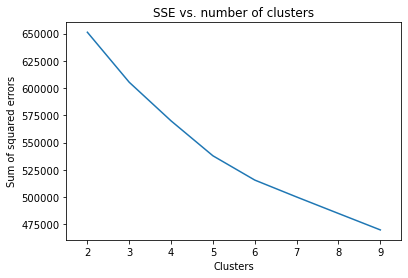

In [28]:
# As an alternative, look for an elbow in the within-cluster SSE (k-means example):
SSE = []
for i in range(2,10):
    km = KMeans(n_clusters = i)
    res=km.fit(scaled_features)
    SSE.append(res.inertia_)
print(SSE)

plt.gca()
plt.plot(range(2,10),SSE)
plt.xlabel("Clusters")
plt.ylabel("Sum of squared errors")
plt.title("SSE vs. number of clusters")
plt.xlim(1.5,9.5)
plt.show()

Cluster assignments: [0 1 1 ... 0 0 0]

Cluster centers:
 [[-4.89761854e-02 -9.13539913e-02 -4.22359906e-03 -2.07530455e-01
  -9.43705813e-02 -9.51448492e-02 -9.25690035e-02 -1.15573828e-01
  -8.09202953e-02  4.17159388e-02 -1.71156369e-01 -2.14632646e-01
  -1.77281640e-01 -2.45377418e-01 -2.16010374e-01 -2.33641481e-01
  -8.60496744e-02 -1.34888660e-02 -2.98818670e-02  2.26056024e-01
  -3.20611240e-01 -3.66797337e-01  9.39315962e-02 -3.15338147e-01
  -3.17818249e-01 -2.83977031e-01 -3.59472666e-01 -2.68329122e-01
  -1.51864441e-01 -3.27374333e-01  1.05126597e-03 -1.63248987e-01
  -3.78029531e-02 -6.14953898e-02 -1.40930918e-02 -8.53897250e-04
  -1.04762062e-01 -3.18179249e-01  9.95617920e-02 -4.32651297e-01
  -2.04998500e-01 -3.46869083e-01 -3.36309917e-01 -3.37785706e-01
  -2.75308380e-01 -3.72011490e-01 -4.24030956e-01 -3.55113976e-01
  -3.40168141e-01 -2.71666754e-01  2.94151747e-02  7.74348702e-02
   1.60258393e-01 -1.85966921e-01  0.00000000e+00 -4.79585489e-02
  -1.55441589e-01 

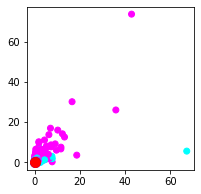

In [110]:
km = KMeans(random_state=234,n_clusters=2)
res=km.fit(scaled_features)

print('Cluster assignments:',res.labels_)
print('\nCluster centers:\n',res.cluster_centers_)
print('\nSum of squared errors:',res.inertia_)

# plot points and cluster assigments
plt.figure(figsize=(3,3))
plt.scatter(scaled_features[:,0],scaled_features[:,1],c=res.labels_,cmap=plt.cm.cool)
plt.scatter(res.cluster_centers_[0,0],res.cluster_centers_[0,1],c="b",s=100)
plt.scatter(res.cluster_centers_[1,0],res.cluster_centers_[1,1],c="r",s=100)
plt.show()

In [111]:
#adding clusters to dataframe
df_box['cluster_all_predictors'] = res.labels_
df_box.head()

,borobox,lotarea,bldgarea,numbldgs,numfloors,unitsres,unitstotal,assessland,assesstot,exempttot,...,pctrentocch,crowding,crowdingrenter,engines_assigned_quantity,ladders_assigned_quantity,dispatch_response_seconds_qy,num_fire_ev,avg_fire_ev_yr,cluster,cluster_all_predictors
0,B0020,3457.956522,9239.391304,1.173913,3.521739,9.000000,9.043478,3.718826e+04,8.482943e+05,2.937391e+03,...,82.125307,6.511057,6.806283,3.500000,2.333333,32.666667,6,1.200000,0,0
1,B0023,26081.875000,209572.375000,1.000000,18.750000,229.750000,231.125000,1.322048e+06,1.219295e+07,2.589945e+06,...,89.917577,8.626047,7.280303,3.000000,2.000000,42.333333,3,3.000000,0,1
2,B0024,2754.847826,4832.108696,1.086957,3.217391,5.695652,5.847826,4.959654e+04,5.346010e+05,4.643715e+04,...,90.034364,8.719931,7.156489,3.200000,2.040000,36.880000,25,1.923077,0,1
3,B0025,61653.000000,85292.250000,1.250000,10.750000,101.500000,102.000000,8.558175e+05,3.580575e+06,2.746800e+06,...,90.034364,8.719931,7.156489,2.400000,1.600000,15.600000,5,1.666667,0,1
4,B0027,3888.574713,8242.965517,1.126437,3.183908,7.080460,7.402299,4.881548e+04,6.619610e+05,1.669940e+05,...,90.034364,8.719931,7.156489,3.545455,2.340909,32.181818,44,2.933333,0,1


In [112]:
all_predictors = pd.merge(df_box, borobox, how='inner', on='borobox')

all_predictors

,borobox,lotarea,bldgarea,numbldgs,numfloors,unitsres,unitstotal,assessland,assesstot,exempttot,...,crowding,crowdingrenter,engines_assigned_quantity,ladders_assigned_quantity,dispatch_response_seconds_qy,num_fire_ev,avg_fire_ev_yr,cluster,cluster_all_predictors,geometry
0,B0020,3457.956522,9239.391304,1.173913,3.521739,9.000000,9.043478,3.718826e+04,8.482943e+05,2.937391e+03,...,6.511057,6.806283,3.500000,2.333333,32.666667,6,1.200000,0,0,"POLYGON ((996589.357 203761.038, 996453.584 20..."
1,B0023,26081.875000,209572.375000,1.000000,18.750000,229.750000,231.125000,1.322048e+06,1.219295e+07,2.589945e+06,...,8.626047,7.280303,3.000000,2.000000,42.333333,3,3.000000,0,1,"POLYGON ((995490.702 207449.105, 995167.181 20..."
2,B0024,2754.847826,4832.108696,1.086957,3.217391,5.695652,5.847826,4.959654e+04,5.346010e+05,4.643715e+04,...,8.719931,7.156489,3.200000,2.040000,36.880000,25,1.923077,0,1,"POLYGON ((995718.069 206877.230, 995626.619 20..."
3,B0025,61653.000000,85292.250000,1.250000,10.750000,101.500000,102.000000,8.558175e+05,3.580575e+06,2.746800e+06,...,8.719931,7.156489,2.400000,1.600000,15.600000,5,1.666667,0,1,"POLYGON ((995642.617 206803.105, 995091.457 20..."
4,B0027,3888.574713,8242.965517,1.126437,3.183908,7.080460,7.402299,4.881548e+04,6.619610e+05,1.669940e+05,...,8.719931,7.156489,3.545455,2.340909,32.181818,44,2.933333,0,1,"POLYGON ((995808.521 206099.291, 995459.101 20..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10859,X4978,13611.500000,31399.111111,1.111111,3.277778,22.944444,27.666667,1.475517e+05,9.007483e+05,5.954489e+04,...,0.511408,0.884354,2.696970,1.878788,46.303030,33,2.357143,0,0,"POLYGON ((1009067.178 263280.356, 1008851.782 ..."
10860,X4981,15973.769231,50165.000000,1.692308,3.538462,40.230769,40.230769,2.006309e+05,1.288421e+06,3.477946e+04,...,1.848746,4.064422,3.083333,2.166667,29.333333,12,1.333333,0,0,"POLYGON ((1011004.582 262701.718, 1010818.235 ..."
10861,X4982,11057.809524,3360.285714,1.095238,2.190476,1.047619,1.047619,2.705429e+04,1.204286e+05,2.555143e+04,...,1.173006,2.671453,2.000000,1.333333,59.666667,3,1.000000,0,0,"POLYGON ((1010997.445 264005.246, 1010998.507 ..."
10862,X4985,15604.521739,11903.260870,1.217391,2.695652,11.869565,11.869565,1.316296e+05,3.087378e+05,2.570439e+05,...,4.530011,10.122699,3.000000,2.666667,48.333333,3,1.500000,0,0,"POLYGON ((1011128.410 267860.427, 1010710.689 ..."


In [113]:
all_predictors = gpd.GeoDataFrame(all_predictors, geometry='geometry')

<AxesSubplot:>

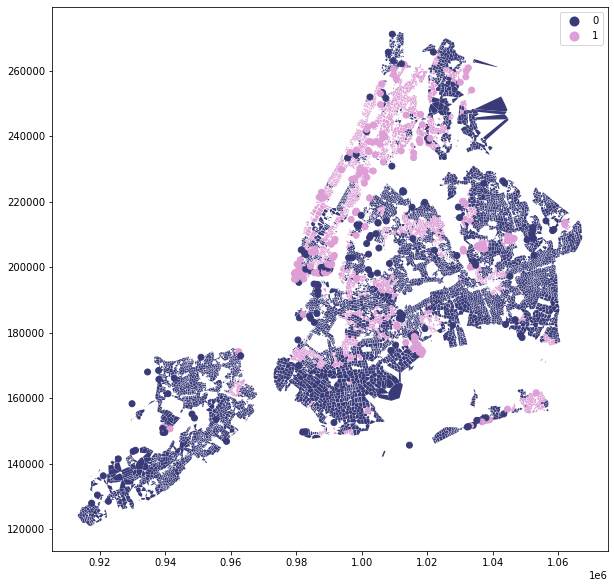

In [116]:
fig, ax = plt.subplots(1, figsize=(15,10))
all_predictors.plot(column='cluster_all_predictors',categorical=True, ax=ax, legend=True, cmap='tab20b')

In [78]:
#IMPORTANT FEATURES ONLY

#determine the number of clusters using the silhouette score 
range_n_clusters = range(2,10)


for n_clusters in range_n_clusters:
    clusterer = KMeans(n_clusters=n_clusters, random_state=234)
    cluster_labels=clusterer.fit_predict(scaled_imp_feat)    
    silhouette_avg = silhouette_score(scaled_imp_feat, cluster_labels)
    print("For n_clusters = {},".format(n_clusters)+" the average silhouette_score is : {}".format(silhouette_avg))

For n_clusters = 2, the average silhouette_score is : 0.9557346539239623
For n_clusters = 3, the average silhouette_score is : 0.5831039924564787
For n_clusters = 4, the average silhouette_score is : 0.3467226935974147
For n_clusters = 5, the average silhouette_score is : 0.35358498240694525
For n_clusters = 6, the average silhouette_score is : 0.35390705336186096
For n_clusters = 7, the average silhouette_score is : 0.28872560879988396
For n_clusters = 8, the average silhouette_score is : 0.3168866534470009
For n_clusters = 9, the average silhouette_score is : 0.3346877236550937


Cluster assignments: [0 0 0 ... 0 0 0]

Cluster centers:
 [[-1.59348722e-02 -1.50844665e-02 -1.70342354e-02 -1.26558505e-03
  -1.58555672e-02 -1.95746941e-03 -1.58801414e-02 -5.62602731e-04
  -4.27840190e-03  4.17624585e-04]
 [ 2.47149868e+01  2.33960075e+01  2.64200992e+01  1.96292242e+00
   2.45919848e+01  3.03603506e+00  2.46300992e+01  8.72596836e-01
   6.63580134e+00 -6.47735731e-01]]

Sum of squared errors: 86744.46391628527


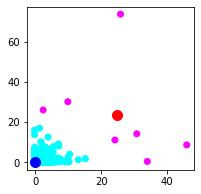

In [79]:
km = KMeans(random_state=234,n_clusters=2)
res=km.fit(scaled_imp_feat)

print('Cluster assignments:',res.labels_)
print('\nCluster centers:\n',res.cluster_centers_)
print('\nSum of squared errors:',res.inertia_)

# plot points and cluster assigments
plt.figure(figsize=(3,3))
plt.scatter(scaled_imp_feat[:,0],scaled_imp_feat[:,1],c=res.labels_,cmap=plt.cm.cool)
plt.scatter(res.cluster_centers_[0,0],res.cluster_centers_[0,1],c="b",s=100)
plt.scatter(res.cluster_centers_[1,0],res.cluster_centers_[1,1],c="r",s=100)
plt.show()

In [80]:
#adding clusters to dataframe
df_box['cluster'] = res.labels_
df_box.head()

,borobox,lotarea,bldgarea,numbldgs,numfloors,unitsres,unitstotal,assessland,assesstot,exempttot,...,pctownerocch,pctrentocch,crowding,crowdingrenter,engines_assigned_quantity,ladders_assigned_quantity,dispatch_response_seconds_qy,num_fire_ev,avg_fire_ev_yr,cluster
0,B0020,3457.956522,9239.391304,1.173913,3.521739,9.000000,9.043478,3.718826e+04,8.482943e+05,2.937391e+03,...,17.874693,82.125307,6.511057,6.806283,3.500000,2.333333,32.666667,6,1.200000,0
1,B0023,26081.875000,209572.375000,1.000000,18.750000,229.750000,231.125000,1.322048e+06,1.219295e+07,2.589945e+06,...,10.082423,89.917577,8.626047,7.280303,3.000000,2.000000,42.333333,3,3.000000,0
2,B0024,2754.847826,4832.108696,1.086957,3.217391,5.695652,5.847826,4.959654e+04,5.346010e+05,4.643715e+04,...,9.965636,90.034364,8.719931,7.156489,3.200000,2.040000,36.880000,25,1.923077,0
3,B0025,61653.000000,85292.250000,1.250000,10.750000,101.500000,102.000000,8.558175e+05,3.580575e+06,2.746800e+06,...,9.965636,90.034364,8.719931,7.156489,2.400000,1.600000,15.600000,5,1.666667,0
4,B0027,3888.574713,8242.965517,1.126437,3.183908,7.080460,7.402299,4.881548e+04,6.619610e+05,1.669940e+05,...,9.965636,90.034364,8.719931,7.156489,3.545455,2.340909,32.181818,44,2.933333,0


In [82]:
#merge to geojson

EM_IMP_FEAT = pd.merge(df_box, borobox, how='inner', on='borobox')

EM_IMP_FEAT

,borobox,lotarea,bldgarea,numbldgs,numfloors,unitsres,unitstotal,assessland,assesstot,exempttot,...,pctrentocch,crowding,crowdingrenter,engines_assigned_quantity,ladders_assigned_quantity,dispatch_response_seconds_qy,num_fire_ev,avg_fire_ev_yr,cluster,geometry
0,B0020,3457.956522,9239.391304,1.173913,3.521739,9.000000,9.043478,3.718826e+04,8.482943e+05,2.937391e+03,...,82.125307,6.511057,6.806283,3.500000,2.333333,32.666667,6,1.200000,0,"POLYGON ((996589.357 203761.038, 996453.584 20..."
1,B0023,26081.875000,209572.375000,1.000000,18.750000,229.750000,231.125000,1.322048e+06,1.219295e+07,2.589945e+06,...,89.917577,8.626047,7.280303,3.000000,2.000000,42.333333,3,3.000000,0,"POLYGON ((995490.702 207449.105, 995167.181 20..."
2,B0024,2754.847826,4832.108696,1.086957,3.217391,5.695652,5.847826,4.959654e+04,5.346010e+05,4.643715e+04,...,90.034364,8.719931,7.156489,3.200000,2.040000,36.880000,25,1.923077,0,"POLYGON ((995718.069 206877.230, 995626.619 20..."
3,B0025,61653.000000,85292.250000,1.250000,10.750000,101.500000,102.000000,8.558175e+05,3.580575e+06,2.746800e+06,...,90.034364,8.719931,7.156489,2.400000,1.600000,15.600000,5,1.666667,0,"POLYGON ((995642.617 206803.105, 995091.457 20..."
4,B0027,3888.574713,8242.965517,1.126437,3.183908,7.080460,7.402299,4.881548e+04,6.619610e+05,1.669940e+05,...,90.034364,8.719931,7.156489,3.545455,2.340909,32.181818,44,2.933333,0,"POLYGON ((995808.521 206099.291, 995459.101 20..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10859,X4978,13611.500000,31399.111111,1.111111,3.277778,22.944444,27.666667,1.475517e+05,9.007483e+05,5.954489e+04,...,57.828482,0.511408,0.884354,2.696970,1.878788,46.303030,33,2.357143,0,"POLYGON ((1009067.178 263280.356, 1008851.782 ..."
10860,X4981,15973.769231,50165.000000,1.692308,3.538462,40.230769,40.230769,2.006309e+05,1.288421e+06,3.477946e+04,...,44.068432,1.848746,4.064422,3.083333,2.166667,29.333333,12,1.333333,0,"POLYGON ((1011004.582 262701.718, 1010818.235 ..."
10861,X4982,11057.809524,3360.285714,1.095238,2.190476,1.047619,1.047619,2.705429e+04,1.204286e+05,2.555143e+04,...,45.685366,1.173006,2.671453,2.000000,1.333333,59.666667,3,1.000000,0,"POLYGON ((1010997.445 264005.246, 1010998.507 ..."
10862,X4985,15604.521739,11903.260870,1.217391,2.695652,11.869565,11.869565,1.316296e+05,3.087378e+05,2.570439e+05,...,36.919592,4.530011,10.122699,3.000000,2.666667,48.333333,3,1.500000,0,"POLYGON ((1011128.410 267860.427, 1010710.689 ..."


In [85]:
EM_IMP_FEAT = gpd.GeoDataFrame(EM_IMP_FEAT, geometry='geometry')

<AxesSubplot:>

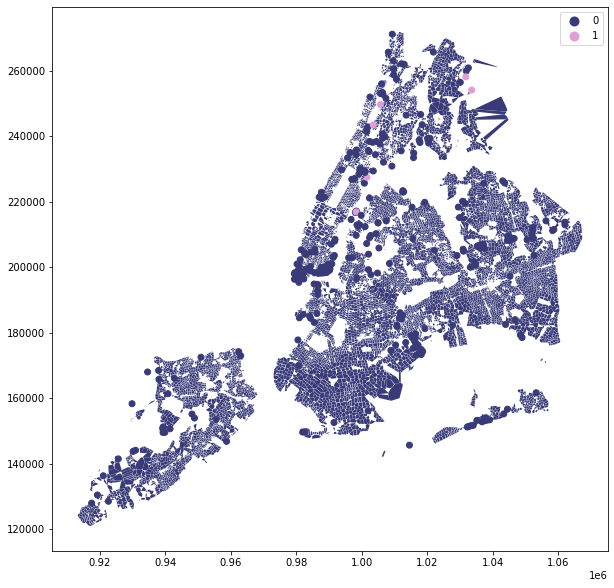

In [102]:
fig, ax = plt.subplots(1, figsize=(15,10))
EM_IMP_FEAT.plot(column='cluster',categorical=True, ax=ax, legend=True, cmap='tab20b')

In [104]:
EM_IMP_FEAT.loc[EM_IMP_FEAT['cluster'] == 1]

,borobox,lotarea,bldgarea,numbldgs,numfloors,unitsres,unitstotal,assessland,assesstot,exempttot,...,pctrentocch,crowding,crowdingrenter,engines_assigned_quantity,ladders_assigned_quantity,dispatch_response_seconds_qy,num_fire_ev,avg_fire_ev_yr,cluster,geometry
3167,M1331,519220.0,2046455.0,4.0,31.0,1594.0,1604.0,14490450.0,70344900.0,70344900.0,...,89.892729,7.032181,6.974277,0.000000,0.000000,0.000000,1,0.000000,1,POINT (1001506.184 227424.063)
3564,M1947,4231466.0,4786701.0,38.0,18.0,8018.0,8088.0,134506350.0,443556000.0,443556000.0,...,66.277518,11.774516,15.299446,3.090909,2.272727,103.181818,11,1.833333,1,POINT (998234.893 216886.338)
9869,X2520,19887.0,89457.0,1.0,6.0,94.0,95.0,134100.0,1864350.0,0.0,...,99.146067,11.550562,11.650045,0.000000,0.000000,0.000000,2,0.000000,1,POINT (1003463.472 243424.723)
10126,X3007,1449960.5,2610900.0,50.5,6.5,3617.5,3617.5,14354178.0,73357775.5,39746578.0,...,79.129228,12.466692,12.044988,3.250000,2.230769,34.211538,52,3.058824,1,"LINESTRING (1023303.109 245551.148, 1023849.55..."
10723,X4382,1952770.0,5541031.0,37.0,33.0,4458.0,4470.0,17574750.0,109098900.0,109098900.0,...,49.792835,4.655130,3.279491,3.158730,2.063492,36.301587,63,3.705882,1,POINT (1033495.426 254073.763)
10763,X4487,5048550.0,13540113.0,250.0,33.0,10914.0,10948.0,25285500.0,204495300.0,204495300.0,...,54.569934,5.585475,6.964613,3.210526,2.110526,32.584211,190,11.176471,1,POINT (1031717.850 258115.476)
10790,X4723,856800.0,1597950.0,6.0,44.0,1654.0,1660.0,11566800.0,49701600.0,49701600.0,...,100.000000,8.837485,8.837485,3.353659,2.271777,34.512195,574,33.764706,1,POINT (1005649.494 249646.724)


D. GAUSSIAN MIXTURE

In [117]:
# ALL PREDICTORS
range_n_clusters = range(2,10)


for n_clusters in range_n_clusters:
    clusterer = GaussianMixture(n_components=n_clusters, random_state=234)
    cluster_labels=clusterer.fit_predict(scaled_features)    
    silhouette_avg = silhouette_score(scaled_features, cluster_labels)
    print("For n_clusters = {},".format(n_clusters)+" the average silhouette_score is : {}".format(silhouette_avg))

For n_clusters = 2, the average silhouette_score is : 0.22085129748837348
For n_clusters = 3, the average silhouette_score is : 0.053575306091152304
For n_clusters = 4, the average silhouette_score is : 0.023614026367842315
For n_clusters = 5, the average silhouette_score is : 0.03599554079533439
For n_clusters = 6, the average silhouette_score is : 0.014982752588975187
For n_clusters = 7, the average silhouette_score is : 0.035551322849817615
For n_clusters = 8, the average silhouette_score is : 0.031592895297602785
For n_clusters = 9, the average silhouette_score is : 0.035376673719979386


In [118]:
gmm = GaussianMixture(n_components=2,random_state=100)
res = gmm.fit(scaled_features)

print('Probabilities of belonging to cluster 1:\n',res.predict_proba(scaled_features)[:,1])
print('\nCluster centers:\n',res.means_)
print('\nCluster covariances:\n',res.covariances_)
print('\nLog-likelihood per sample:',res.score(scaled_features))

Probabilities of belonging to cluster 1:
 [1.60727841e-09 0.00000000e+00 1.00000000e+00 ... 1.00000000e+00
 1.23671940e-19 1.00000000e+00]

Cluster centers:
 [[ 2.01324981e-01  3.32199589e-01  9.03461397e-02  7.99793053e-01
   3.31679731e-01  3.37649078e-01  3.55101370e-01  4.42904710e-01
   2.56174075e-01 -1.75562044e-01  4.94969791e-01  6.02208171e-01
   5.04734179e-01  5.61540102e-01  5.42207014e-01  5.42845099e-01
   3.30475917e-01  1.46966738e-01  1.10278808e-01 -9.93906602e-01
   6.35116449e-01  8.82628178e-01 -2.63190714e-01  6.02127836e-01
   6.49177381e-01  3.88465858e-01  7.81939389e-01  5.28740910e-01
   4.06745369e-01  5.44539367e-01  1.53460674e-01  2.57372274e-01
   8.65658585e-02  6.71696319e-02  4.96711762e-02 -7.00946477e-02
   3.40491940e-01  8.09848529e-01 -1.73406971e-01  1.04706327e+00
   6.26568918e-01  8.44896712e-01  4.77127876e-01  6.72895963e-01
   4.32085839e-01  9.89035256e-01  1.02014683e+00  5.45265633e-01
   6.66130534e-01  4.24362383e-01 -9.91077317e-02 

In [64]:
range_n_clusters = range(2,10)


for n_clusters in range_n_clusters:
    clusterer = GaussianMixture(n_components=n_clusters, random_state=234)
    cluster_labels=clusterer.fit_predict(scaled_imp_feat)    
    silhouette_avg = silhouette_score(scaled_imp_feat, cluster_labels)
    print("For n_clusters = {},".format(n_clusters)+" the average silhouette_score is : {}".format(silhouette_avg))

For n_clusters = 2, the average silhouette_score is : 0.9557346539239623
For n_clusters = 3, the average silhouette_score is : 0.9481707781380376
For n_clusters = 4, the average silhouette_score is : 0.20039694391268834
For n_clusters = 5, the average silhouette_score is : 0.011789194911679948
For n_clusters = 6, the average silhouette_score is : -0.01650472989338079
For n_clusters = 7, the average silhouette_score is : -0.0057871077268662075
For n_clusters = 8, the average silhouette_score is : 0.034979471349925975
For n_clusters = 9, the average silhouette_score is : -0.013464545906781228


In [65]:
gmm = GaussianMixture(n_components=2,random_state=100)
res = gmm.fit(scaled_imp_feat)

print('Probabilities of belonging to cluster 1:\n',res.predict_proba(scaled_imp_feat)[:,1])
print('\nCluster centers:\n',res.means_)
print('\nCluster covariances:\n',res.covariances_)
print('\nLog-likelihood per sample:',res.score(scaled_imp_feat))

Probabilities of belonging to cluster 1:
 [0.9999998  0.         1.         ... 1.         0.01571035 1.        ]

Cluster centers:
 [[ 0.52214509  0.32634126  0.51078997  0.67922246  0.33211184  0.2733006
   0.32623198  0.00661706  0.64174232  0.03698521]
 [-0.20016691 -0.12510454 -0.19581388 -0.2603833  -0.12731672 -0.10477114
  -0.12506265 -0.00253668 -0.24601511 -0.01417847]]

Cluster covariances:
 [[[ 3.22444898e+00  1.22502493e+00  3.16454348e+00  1.10003014e+00
    1.19088881e+00  1.25078849e-01  1.19764895e+00  2.42393134e-01
    1.83064757e+00 -5.29137164e-01]
  [ 1.22502493e+00  3.46099046e+00  1.67889303e+00 -3.74603681e-01
    3.24804775e+00  5.86773294e-01  3.25056680e+00  4.94170648e-02
   -1.67365901e-01 -2.65831907e-02]
  [ 3.16454348e+00  1.67889303e+00  3.23942583e+00  9.57217383e-01
    1.57860938e+00  2.30728355e-01  1.58603999e+00  2.32258451e-01
    1.62089332e+00 -4.94037453e-01]
  [ 1.10003014e+00 -3.74603681e-01  9.57217383e-01  2.44378961e+00
   -3.71463774e-0

In [ ]:
PART II: CLUSTER ANALYSIS WITH TARGET VARIABLE (RELATIONSHIPS BETWEEN DATA)

In [33]:
df_box.columns

Index(['borobox', 'lotarea', 'bldgarea', 'numbldgs', 'numfloors', 'unitsres',
       'unitstotal', 'assessland', 'assesstot', 'exempttot', 'yearbuilt',
       'holc_AB', 'holc_CD', 'holc_D', 'tot_hpd_vio', 'hpd_fire_vio',
       'hpd_b_c_vio', 'viol_count_per_unit', 'hpd_fire_vio_per_unit',
       'hpd_b_c_vio_per_unit', 'AL', 'NB', 'average_energy_usage',
       'average_energy_usage_mi', 'totpop', 'popdens', 'areasqmile', 'males',
       'females', 'pop18under', 'pop18_34', 'pop35_64', 'pop65plus',
       'pophispanic', 'popnhwhite', 'popnhblack', 'popnhaian', 'popnhasian',
       'popnhhawainpi', 'popnhother', 'popnhtwoplus', 'housing',
       'housingoccupied', 'renterhousing', 'oc_halfless', 'oc_half_1',
       'oc_1_onehalf', 'oc_onehalf_2', 'oc_2plus', 'roc_halfless',
       'roc_half_1', 'roc_1_onehalf', 'roc_onehalf_2', 'roc_2plus',
       'medianyearbuilt', 'mediangrossrent', 'medianhhincome', 'gini', 'year',
       'pct18under', 'pct18_34', 'pct35_64', 'pct65plus', 'pcthispa

In [35]:
df_box.iloc[:,1:74]

,lotarea,bldgarea,numbldgs,numfloors,unitsres,unitstotal,assessland,assesstot,exempttot,yearbuilt,...,pctnhwhite,pctnhblack,pctnhaian,pctnhasian,pctnhhawainpi,pctnhother,pctnhtwoplus,pctownerocch,pctrentocch,crowding
0,3457.956522,9239.391304,1.173913,3.521739,9.000000,9.043478,3.718826e+04,8.482943e+05,2.937391e+03,1929.000000,...,75.014132,5.907292,1.130582,6.444319,0.0,2.091577,3.109101,17.874693,82.125307,6.511057
1,26081.875000,209572.375000,1.000000,18.750000,229.750000,231.125000,1.322048e+06,1.219295e+07,2.589945e+06,1995.750000,...,56.172059,5.007916,0.000000,8.927436,0.0,0.076276,4.795929,10.082423,89.917577,8.626047
2,2754.847826,4832.108696,1.086957,3.217391,5.695652,5.847826,4.959654e+04,5.346010e+05,4.643715e+04,1930.347826,...,56.400742,5.176252,0.000000,6.437848,0.0,0.000000,4.842301,9.965636,90.034364,8.719931
3,61653.000000,85292.250000,1.250000,10.750000,101.500000,102.000000,8.558175e+05,3.580575e+06,2.746800e+06,1958.250000,...,56.400742,5.176252,0.000000,6.437848,0.0,0.000000,4.842301,9.965636,90.034364,8.719931
4,3888.574713,8242.965517,1.126437,3.183908,7.080460,7.402299,4.881548e+04,6.619610e+05,1.669940e+05,1929.057471,...,56.400742,5.176252,0.000000,6.437848,0.0,0.000000,4.842301,9.965636,90.034364,8.719931
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10859,13611.500000,31399.111111,1.111111,3.277778,22.944444,27.666667,1.475517e+05,9.007483e+05,5.954489e+04,1978.666667,...,71.673070,10.495983,0.000000,3.562696,0.0,0.943067,2.759343,42.171518,57.828482,0.511408
10860,15973.769231,50165.000000,1.692308,3.538462,40.230769,40.230769,2.006309e+05,1.288421e+06,3.477946e+04,1788.615385,...,67.344026,5.998493,0.000000,5.958270,0.0,0.352624,2.214461,55.931568,44.068432,1.848746
10861,11057.809524,3360.285714,1.095238,2.190476,1.047619,1.047619,2.705429e+04,1.204286e+05,2.555143e+04,1931.714286,...,60.663018,6.467723,0.000000,4.819578,0.0,0.238157,2.297518,54.314634,45.685366,1.173006
10862,15604.521739,11903.260870,1.217391,2.695652,11.869565,11.869565,1.316296e+05,3.087378e+05,2.570439e+05,1958.913043,...,61.483538,4.839349,0.000000,7.338358,0.0,0.000000,2.737009,63.080408,36.919592,4.530011


In [120]:
df_box.columns
all_fields = [ 'lotarea', 'bldgarea', 'numbldgs', 'numfloors', 'unitsres',
              'unitstotal', 'assessland', 'assesstot', 'exempttot', 'yearbuilt', #'holc_AB', 'holc_CD', 'holc_D', 
              'tot_hpd_vio', 'hpd_fire_vio','hpd_b_c_vio', 'viol_count_per_unit', 'hpd_fire_vio_per_unit',
              'hpd_b_c_vio_per_unit', 'AL', 'NB', 'average_energy_usage',
              'average_energy_usage_mi', 'totpop', 'popdens', 'areasqmile', 'males',
              'females', 'pop18under', 'pop18_34', 'pop35_64', 'pop65plus',
              'pophispanic', 'popnhwhite', 'popnhblack', 'popnhaian', 'popnhasian',
              'popnhhawainpi', 'popnhother', 'popnhtwoplus', 'housing',
              'housingoccupied', 'renterhousing', 'oc_halfless', 'oc_half_1',
              'oc_1_onehalf', 'oc_onehalf_2', 'oc_2plus', 'roc_halfless',
              'roc_half_1', 'roc_1_onehalf', 'roc_onehalf_2', 'roc_2plus',
              'medianyearbuilt', 'mediangrossrent', 'medianhhincome', 'gini', 'year',
              'pct18under', 'pct18_34', 'pct35_64', 'pct65plus', 'pcthispanic',
              'pctnhwhite', 'pctnhblack', 'pctnhaian', 'pctnhasian', 'pctnhhawainpi',
              'pctnhother', 'pctnhtwoplus', 'pctownerocch', 'pctrentocch', 'crowding',
              'crowdingrenter', 'engines_assigned_quantity',
              'ladders_assigned_quantity', 'dispatch_response_seconds_qy','num_fire_ev', 'avg_fire_ev_yr']


In [121]:
df_box2 = df_box.loc[:, all_fields].fillna(0)
df_box2

,lotarea,bldgarea,numbldgs,numfloors,unitsres,unitstotal,assessland,assesstot,exempttot,yearbuilt,...,pctnhtwoplus,pctownerocch,pctrentocch,crowding,crowdingrenter,engines_assigned_quantity,ladders_assigned_quantity,dispatch_response_seconds_qy,num_fire_ev,avg_fire_ev_yr
0,3457.956522,9239.391304,1.173913,3.521739,9.000000,9.043478,3.718826e+04,8.482943e+05,2.937391e+03,1929.000000,...,3.109101,17.874693,82.125307,6.511057,6.806283,3.500000,2.333333,32.666667,6,1.200000
1,26081.875000,209572.375000,1.000000,18.750000,229.750000,231.125000,1.322048e+06,1.219295e+07,2.589945e+06,1995.750000,...,4.795929,10.082423,89.917577,8.626047,7.280303,3.000000,2.000000,42.333333,3,3.000000
2,2754.847826,4832.108696,1.086957,3.217391,5.695652,5.847826,4.959654e+04,5.346010e+05,4.643715e+04,1930.347826,...,4.842301,9.965636,90.034364,8.719931,7.156489,3.200000,2.040000,36.880000,25,1.923077
3,61653.000000,85292.250000,1.250000,10.750000,101.500000,102.000000,8.558175e+05,3.580575e+06,2.746800e+06,1958.250000,...,4.842301,9.965636,90.034364,8.719931,7.156489,2.400000,1.600000,15.600000,5,1.666667
4,3888.574713,8242.965517,1.126437,3.183908,7.080460,7.402299,4.881548e+04,6.619610e+05,1.669940e+05,1929.057471,...,4.842301,9.965636,90.034364,8.719931,7.156489,3.545455,2.340909,32.181818,44,2.933333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10859,13611.500000,31399.111111,1.111111,3.277778,22.944444,27.666667,1.475517e+05,9.007483e+05,5.954489e+04,1978.666667,...,2.759343,42.171518,57.828482,0.511408,0.884354,2.696970,1.878788,46.303030,33,2.357143
10860,15973.769231,50165.000000,1.692308,3.538462,40.230769,40.230769,2.006309e+05,1.288421e+06,3.477946e+04,1788.615385,...,2.214461,55.931568,44.068432,1.848746,4.064422,3.083333,2.166667,29.333333,12,1.333333
10861,11057.809524,3360.285714,1.095238,2.190476,1.047619,1.047619,2.705429e+04,1.204286e+05,2.555143e+04,1931.714286,...,2.297518,54.314634,45.685366,1.173006,2.671453,2.000000,1.333333,59.666667,3,1.000000
10862,15604.521739,11903.260870,1.217391,2.695652,11.869565,11.869565,1.316296e+05,3.087378e+05,2.570439e+05,1958.913043,...,2.737009,63.080408,36.919592,4.530011,10.122699,3.000000,2.666667,48.333333,3,1.500000


In [122]:
#standardize all variables
scaled_data = scale(df_box2)

In [123]:
scaled_data

array([[-0.08608155, -0.08982108, -0.05625081, ..., -0.41455412,
        -0.45196265, -0.42184674],
       [ 0.10641036,  1.00262214, -0.06913419, ...,  0.10798645,
        -0.51372908,  0.22092313],
       [-0.09206384, -0.11385459, -0.0626925 , ..., -0.18679851,
        -0.06077527, -0.16364004],
       ...,
       [-0.02141945, -0.12188064, -0.062079  , ...,  1.04495575,
        -0.51372908, -0.49326561],
       [ 0.01726551, -0.07529463, -0.05302996, ...,  0.43232198,
        -0.51372908, -0.31471843],
       [-0.04763349, -0.12492885, -0.06913419, ...,  1.02693711,
        -0.51372908, -0.49326561]])

In [73]:
#important features only
imp_feat = ["hpd_b_c_vio", "bldgarea", "tot_hpd_vio", "hpd_b_c_vio_per_unit", "unitstotal", "pop65plus",
           "unitsres","pctnhblack","hpd_fire_vio","mediangrossrent", 'num_fire_ev', 'avg_fire_ev_yr']

imp_feat = df_box.loc[:, imp_feat].fillna(0)
imp_feat

,hpd_b_c_vio,bldgarea,tot_hpd_vio,hpd_b_c_vio_per_unit,unitstotal,pop65plus,unitsres,pctnhblack,hpd_fire_vio,mediangrossrent,num_fire_ev,avg_fire_ev_yr
0,7.739130,9239.391304,14.608696,0.957782,9.043478,431.000000,9.000000,5.907292,0.086957,2093.000000,6,1.200000
1,1.125000,209572.375000,3.750000,0.010057,231.125000,568.750000,229.750000,5.007916,0.000000,2170.250000,3,3.000000
2,4.586957,4832.108696,8.804348,0.712707,5.847826,596.000000,5.695652,5.176252,0.108696,2027.000000,25,1.923077
3,0.000000,85292.250000,3.750000,0.000000,102.000000,596.000000,101.500000,5.176252,0.000000,2027.000000,5,1.666667
4,9.632184,8242.965517,16.114943,1.405932,7.402299,596.000000,7.080460,5.176252,0.183908,2027.000000,44,2.933333
...,...,...,...,...,...,...,...,...,...,...,...,...
10859,4.500000,31399.111111,7.333333,0.025093,27.666667,1699.000000,22.944444,10.495983,0.000000,1963.000000,33,2.357143
10860,22.000000,50165.000000,30.230769,0.940423,40.230769,388.769231,40.230769,5.998493,0.153846,1602.384615,12,1.333333
10861,0.000000,3360.285714,0.000000,0.000000,1.047619,407.428571,1.047619,6.467723,0.000000,1647.571429,3,1.000000
10862,0.000000,11903.260870,0.000000,0.000000,11.869565,593.000000,11.869565,4.839349,0.000000,1720.000000,3,1.500000


A. K-MEANS

In [124]:
#determine the number of clusters using the silhouette score
range_n_clusters = range(2,10)


for n_clusters in range_n_clusters:
    clusterer = KMeans(n_clusters=n_clusters, random_state=234)
    cluster_labels=clusterer.fit_predict(scaled_data)    
    silhouette_avg = silhouette_score(scaled_data, cluster_labels)
    print("For n_clusters = {},".format(n_clusters)+" the average silhouette_score is : {}".format(silhouette_avg))

For n_clusters = 2, the average silhouette_score is : 0.2691178647258001
For n_clusters = 3, the average silhouette_score is : 0.09510023300623194
For n_clusters = 4, the average silhouette_score is : 0.10353939935459198
For n_clusters = 5, the average silhouette_score is : 0.1068798273214118
For n_clusters = 6, the average silhouette_score is : 0.09027776445793137
For n_clusters = 7, the average silhouette_score is : 0.10051456287779845
For n_clusters = 8, the average silhouette_score is : 0.10329857543662287
For n_clusters = 9, the average silhouette_score is : 0.09856211858841797


Cluster assignments: [1 0 0 ... 1 1 1]

Cluster centers:
 [[ 1.47773063e-01  2.77825745e-01  1.08820266e-02  6.35081749e-01
   2.87791949e-01  2.90114584e-01  2.81242238e-01  3.53064448e-01
   2.48989713e-01 -1.32231885e-01  5.29893991e-01  6.66400128e-01
   5.48721513e-01  7.76205755e-01  6.82380050e-01  7.35527014e-01
   2.65370144e-01  3.27005508e-02  9.10937217e-02 -6.88759575e-01
   9.76826528e-01  1.14562429e+00 -2.98227007e-01  9.59248642e-01
   9.69631159e-01  8.68442434e-01  1.10314287e+00  8.11925881e-01
   4.57569915e-01  9.99017986e-01 -1.11393228e-02  5.15792859e-01
   1.17020114e-01  1.72647536e-01  3.96044712e-02 -1.66489477e-03
   3.17229658e-01  9.71944360e-01 -3.22013928e-01  1.33372531e+00
   6.25306353e-01  1.06031397e+00  1.02796712e+00  1.03357526e+00
   8.44915305e-01  1.14949750e+00  1.30558601e+00  1.09112647e+00
   1.04341914e+00  8.35670727e-01 -1.04194939e-01 -2.51974910e-01
  -5.10237820e-01  5.86877404e-01  0.00000000e+00  1.52471973e-01
   4.90570751e-01 

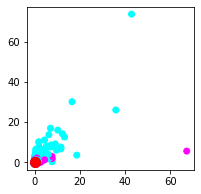

In [125]:
# Use k-means package from sklearn
from sklearn.cluster import KMeans
km = KMeans(random_state=234,n_clusters=2)
res=km.fit(scaled_data)

print('Cluster assignments:',res.labels_)
print('\nCluster centers:\n',res.cluster_centers_)
print('\nSum of squared errors:',res.inertia_)

# plot points and cluster assigments
plt.figure(figsize=(3,3))
plt.scatter(scaled_data[:,0],scaled_data[:,1],c=res.labels_,cmap=plt.cm.cool)
plt.scatter(res.cluster_centers_[0,0],res.cluster_centers_[0,1],c="b",s=100)
plt.scatter(res.cluster_centers_[1,0],res.cluster_centers_[1,1],c="r",s=100)
plt.show()

In [126]:
#adding clusters to dataframe
df_box['cluster_k_outcome'] = res.labels_
df_box.head()

,borobox,lotarea,bldgarea,numbldgs,numfloors,unitsres,unitstotal,assessland,assesstot,exempttot,...,crowding,crowdingrenter,engines_assigned_quantity,ladders_assigned_quantity,dispatch_response_seconds_qy,num_fire_ev,avg_fire_ev_yr,cluster,cluster_all_predictors,cluster_k_outcome
0,B0020,3457.956522,9239.391304,1.173913,3.521739,9.000000,9.043478,3.718826e+04,8.482943e+05,2.937391e+03,...,6.511057,6.806283,3.500000,2.333333,32.666667,6,1.200000,0,0,1
1,B0023,26081.875000,209572.375000,1.000000,18.750000,229.750000,231.125000,1.322048e+06,1.219295e+07,2.589945e+06,...,8.626047,7.280303,3.000000,2.000000,42.333333,3,3.000000,0,1,0
2,B0024,2754.847826,4832.108696,1.086957,3.217391,5.695652,5.847826,4.959654e+04,5.346010e+05,4.643715e+04,...,8.719931,7.156489,3.200000,2.040000,36.880000,25,1.923077,0,1,0
3,B0025,61653.000000,85292.250000,1.250000,10.750000,101.500000,102.000000,8.558175e+05,3.580575e+06,2.746800e+06,...,8.719931,7.156489,2.400000,1.600000,15.600000,5,1.666667,0,1,0
4,B0027,3888.574713,8242.965517,1.126437,3.183908,7.080460,7.402299,4.881548e+04,6.619610e+05,1.669940e+05,...,8.719931,7.156489,3.545455,2.340909,32.181818,44,2.933333,0,1,0


In [127]:
#merge to geojson

k_outcomes = pd.merge(df_box, borobox, how='inner', on='borobox')

k_outcomes

,borobox,lotarea,bldgarea,numbldgs,numfloors,unitsres,unitstotal,assessland,assesstot,exempttot,...,crowdingrenter,engines_assigned_quantity,ladders_assigned_quantity,dispatch_response_seconds_qy,num_fire_ev,avg_fire_ev_yr,cluster,cluster_all_predictors,cluster_k_outcome,geometry
0,B0020,3457.956522,9239.391304,1.173913,3.521739,9.000000,9.043478,3.718826e+04,8.482943e+05,2.937391e+03,...,6.806283,3.500000,2.333333,32.666667,6,1.200000,0,0,1,"POLYGON ((996589.357 203761.038, 996453.584 20..."
1,B0023,26081.875000,209572.375000,1.000000,18.750000,229.750000,231.125000,1.322048e+06,1.219295e+07,2.589945e+06,...,7.280303,3.000000,2.000000,42.333333,3,3.000000,0,1,0,"POLYGON ((995490.702 207449.105, 995167.181 20..."
2,B0024,2754.847826,4832.108696,1.086957,3.217391,5.695652,5.847826,4.959654e+04,5.346010e+05,4.643715e+04,...,7.156489,3.200000,2.040000,36.880000,25,1.923077,0,1,0,"POLYGON ((995718.069 206877.230, 995626.619 20..."
3,B0025,61653.000000,85292.250000,1.250000,10.750000,101.500000,102.000000,8.558175e+05,3.580575e+06,2.746800e+06,...,7.156489,2.400000,1.600000,15.600000,5,1.666667,0,1,0,"POLYGON ((995642.617 206803.105, 995091.457 20..."
4,B0027,3888.574713,8242.965517,1.126437,3.183908,7.080460,7.402299,4.881548e+04,6.619610e+05,1.669940e+05,...,7.156489,3.545455,2.340909,32.181818,44,2.933333,0,1,0,"POLYGON ((995808.521 206099.291, 995459.101 20..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10859,X4978,13611.500000,31399.111111,1.111111,3.277778,22.944444,27.666667,1.475517e+05,9.007483e+05,5.954489e+04,...,0.884354,2.696970,1.878788,46.303030,33,2.357143,0,0,1,"POLYGON ((1009067.178 263280.356, 1008851.782 ..."
10860,X4981,15973.769231,50165.000000,1.692308,3.538462,40.230769,40.230769,2.006309e+05,1.288421e+06,3.477946e+04,...,4.064422,3.083333,2.166667,29.333333,12,1.333333,0,0,1,"POLYGON ((1011004.582 262701.718, 1010818.235 ..."
10861,X4982,11057.809524,3360.285714,1.095238,2.190476,1.047619,1.047619,2.705429e+04,1.204286e+05,2.555143e+04,...,2.671453,2.000000,1.333333,59.666667,3,1.000000,0,0,1,"POLYGON ((1010997.445 264005.246, 1010998.507 ..."
10862,X4985,15604.521739,11903.260870,1.217391,2.695652,11.869565,11.869565,1.316296e+05,3.087378e+05,2.570439e+05,...,10.122699,3.000000,2.666667,48.333333,3,1.500000,0,0,1,"POLYGON ((1011128.410 267860.427, 1010710.689 ..."


In [128]:
k_outcomes = gpd.GeoDataFrame(k_outcomes, geometry='geometry')

<AxesSubplot:>

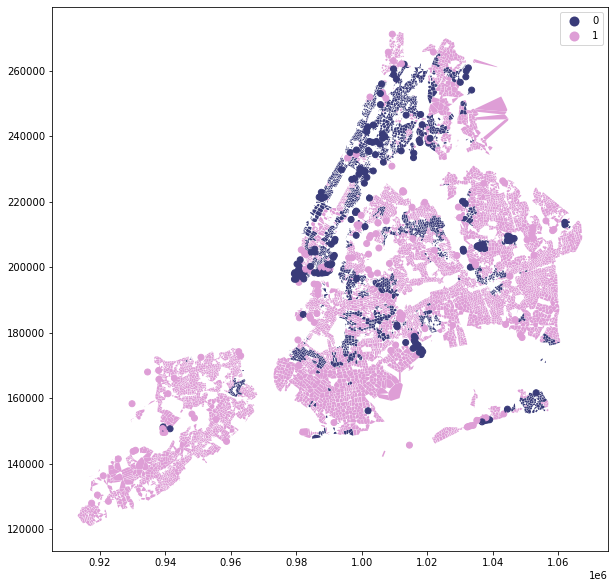

In [130]:
fig, ax = plt.subplots(1, figsize=(15,10))
k_outcomes.plot(column='cluster_k_outcome',categorical=True, ax=ax, legend=True, cmap='tab20b')

B. GAUSSIAN/EM

In [46]:
range_n_clusters = range(2,10)


for n_clusters in range_n_clusters:
    clusterer = GaussianMixture(n_components=n_clusters, random_state=100)
    cluster_labels=clusterer.fit_predict(scaled_data)    
    silhouette_avg = silhouette_score(scaled_data, cluster_labels)
    print("For n_clusters = {},".format(n_clusters)+" the average silhouette_score is : {}".format(silhouette_avg))

For n_clusters = 2, the average silhouette_score is : 0.2121003235511178
For n_clusters = 3, the average silhouette_score is : 0.05293998497137225
For n_clusters = 4, the average silhouette_score is : 0.03334809830261385
For n_clusters = 5, the average silhouette_score is : 0.028817688936786028
For n_clusters = 6, the average silhouette_score is : 0.03327792987956925
For n_clusters = 7, the average silhouette_score is : 0.04570123463651935
For n_clusters = 8, the average silhouette_score is : 0.010176508554062989
For n_clusters = 9, the average silhouette_score is : 0.018372859991763555


Probabilities of belonging to cluster 1:
 [5.65879053e-10 0.00000000e+00 1.00000000e+00 ... 1.00000000e+00
 1.18425068e-20 1.00000000e+00]

Cluster centers:
 [[ 1.98210430e-01  3.27868321e-01  8.86205000e-02  7.93446762e-01
   3.27433513e-01  3.33340493e-01  3.50273555e-01  4.36977509e-01
   2.52678536e-01 -1.78211038e-01  4.94367826e-01  6.06307962e-01
   5.04045401e-01  5.80438299e-01  5.57967273e-01  5.57602990e-01
   3.27006622e-01  1.38304630e-01  1.08976385e-01 -9.83870891e-01
   6.07415598e-01  8.95803250e-01 -2.86903516e-01  5.77558850e-01
   6.19391694e-01  3.71336690e-01  7.64211938e-01  4.96398315e-01
   3.82125204e-01  5.48128347e-01  1.45959586e-01  2.22322476e-01
   8.87787922e-02  6.09518790e-02  4.82686256e-02 -6.91234781e-02
   3.27134313e-01  7.89009797e-01 -2.01391599e-01  1.04208046e+00
   6.05553590e-01  8.27008216e-01  4.77297650e-01  6.59616260e-01
   4.22768074e-01  9.86376882e-01  1.01166185e+00  5.54285988e-01
   6.57603990e-01  4.17602126e-01 -1.17613074e-01 

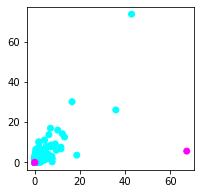

In [49]:
# Use Gaussian mixture models (EM) package from sklearn
from sklearn.mixture import GaussianMixture
from scipy import linalg
import matplotlib as mpl
gmm = GaussianMixture(n_components=2,random_state=100)
res = gmm.fit(scaled_data)

print('Probabilities of belonging to cluster 1:\n',res.predict_proba(scaled_data)[:,1])
print('\nCluster centers:\n',res.means_)
print('\nCluster covariances:\n',res.covariances_)
print('\nLog-likelihood per sample:',res.score(scaled_data))

plt.figure(figsize=(3,3))
splot = plt.subplot(111)

# plot ellipses using mean and covariance matrix for each cluster
colors = ['blue','red']
for i in range(2):
    mean = res.means_[i]
    var = res.covariances_[i]
    v, w = linalg.eigh(var)
    angle = np.arctan2(w[0][1], w[0][0])
    angle = 180. * angle / np.pi  # convert to degrees
    v = 2. * np.sqrt(2.) * np.sqrt(v)
    ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=colors[i])
    ell.set_clip_box(splot.bbox)
    ell.set_alpha(.5)
    splot.add_artist(ell)

# plot points and cluster assigments
plt.scatter(scaled_data[:,0],scaled_data[:,1],c=res.predict_proba(scaled_data)[:,1],cmap=plt.cm.cool)
plt.show()

In [66]:
import geopandas as gpd

In [71]:
borobox = gpd.read_file('/Users/bayerd01/Documents/ML CITIES/borobox_convex_hull.geojson')

borobox

,borobox,geometry
0,B0020,"POLYGON ((996589.357 203761.038, 996453.584 20..."
1,B0023,"POLYGON ((995490.702 207449.105, 995167.181 20..."
2,B0024,"POLYGON ((995718.069 206877.230, 995626.619 20..."
3,B0025,"POLYGON ((995642.617 206803.105, 995091.457 20..."
4,B0027,"POLYGON ((995808.521 206099.291, 995459.101 20..."
...,...,...
10859,X4978,"POLYGON ((1009067.178 263280.356, 1008851.782 ..."
10860,X4981,"POLYGON ((1011004.582 262701.718, 1010818.235 ..."
10861,X4982,"POLYGON ((1010997.445 264005.246, 1010998.507 ..."
10862,X4985,"POLYGON ((1011128.410 267860.427, 1010710.689 ..."


<AxesSubplot:>

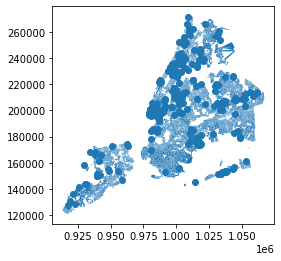

In [72]:
borobox.plot()